In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import batman
import random
from astropy.io import fits
from astropy.io import ascii
from scipy import constants

In [2]:
#Define constants
M_sun = 1.989e+30
R_sun = 695700000
R_Earth = 6378100
day = 86400
AU = 1.496e+11

In [3]:
def LC_read(path):
    '''Reads a lightcurve and returns useful metadata in a pandas dataframe
    and timeseries data'''
    lc = fits.open(path)
    head1 = lc[0].header
    head2 = lc[1].header
    good = (lc[1].data['QUALITY'] == 0)
    f = lc[1].data['PDCSAP_FLUX']
    e = lc[1].data['PDCSAP_FLUX_ERR']
    t = lc[1].data['TIME']
    df = {'TIC-ID':[head1['OBJECT']], 'Sector':[head1['SECTOR']], 
      'Camera':[head1['CAMERA']], 'Chip':[head1['CCD']], 
      'RA':[head1['RA_OBJ']], 'DEC':[head1['DEC_OBJ']],
      'T-MAG':[head1['TESSMAG']], 'T_Eff':[head1['TEFF']],
      'Log-g':[head1['LOGG']], 'Metalicity':[head1['MH']],
      'R_star':[head1['RADIUS']], 'M_star':[np.power(head1['Radius'], 1.25)], 
      'Livetime':[head2['LIVETIME']], 'deadtime-cor':[head2['DEADC']],
      'RMS-Noise':[head2['CDPP2_0']], 'Crowd':[head2['CROWDSAP']],
      'Target-Frac':[head2['FLFRCSAP']], 'Variability':[head2['PDCVAR']]}
    log = pd.DataFrame(df)
    flux = f[good]
    time = t[good]
    fluxerr = e[good]
    return log, flux, time, fluxerr

In [4]:
def planetmaker(rates, radius_low, radius_up, period_low, period_up):
    '''Generates parameters for a planet from occurence rates'''
    rowdex = np.arange(len(rates))
    anglew = np.random.uniform(low=-1.*np.pi, high=np.pi)
    e = np.random.beta(a=1.03, b=13.6)
    rows = np.random.choice(rowdex, p=rates)
    radp = np.random.uniform(low=radius_low[rows], high=radius_up[rows])
    per = np.random.uniform(low=period_low[rows], high=period_up[rows])
    return radp, per, anglew, e

In [5]:
table = ascii.read('norm_rates_FGK.csv', format='csv', header_start=0, data_start=1)
occ = np.array(table['f'], dtype=float)
radbinlower = np.array(table['rmin'], dtype=float)
radbinupper = np.array(table['rmax'], dtype=float)
pbinlower = np.array(table['pmin'], dtype=float)
pbinupper = np.array(table['pmax'], dtype=float)

In [6]:
Path = 'lightcurves\hlsp_tess-spoc_tess_phot_0000000033910247-s0001_tess_v1_lc.fits'

In [7]:
LOG, FLUX, TIME, FLUXERR = LC_read(Path)

In [8]:
print(LOG)

         TIC-ID  Sector  Camera  Chip        RA        DEC    T-MAG   T_Eff  \
0  TIC 33910247       1       3     3  66.45298 -77.586801  12.4455  3853.0   

     Log-g  Metalicity    R_star    M_star   Livetime  deadtime-cor  \
0  4.64588   -0.531169  0.606313  0.535021  22.060298         0.792   

    RMS-Noise     Crowd  Target-Frac  Variability  
0  808.121277  0.967794     0.779815     2.697419  


In [9]:
T_eff = float(LOG['T_Eff'])

In [10]:
#Assign spectral type based on temperature and append to dataframe
if 7500.<= T_eff <10000.:
    spectral_type = 'A'
if 6000.<= T_eff <7500.:
    spectral_type = 'F'
if 5200.<= T_eff <6000.:
    spectral_type = 'G'
if 3700.<= T_eff < 5200.:
    spectral_type = 'K'
if 2400.<= T_eff < 3700.:
    spectral_type = 'M'

In [11]:
LOG['Spectral_type'] = spectral_type

In [38]:
radius, period, peri, ecc = planetmaker(occ, radbinlower, radbinupper, pbinlower, pbinupper)

In [39]:
#Force short period giant planet for testing
#period = np.random.uniform(0.5, 20.)
#radius = np.random.uniform(4., 16.)

In [40]:
#Store parameters to dataframe
LOG['R_p'] = radius
LOG['Period'] = period
LOG['Periastron'] = peri
LOG['Eccentricity'] = ecc

In [41]:
#Extract Radius and Mass
M_star = float(LOG['M_star'])
R_star = float(LOG['R_star'])

In [42]:
#Generate b and cosi such that planet always transits
a = np.cbrt((constants.G*(M_star*M_sun)*np.square(period*day))/(4*np.square(np.pi)))
k = (radius*R_Earth)/(R_star*R_sun)
b = np.random.uniform(low=0., high=1.+k)
cosi = (R_star*R_sun*b*(1.+ecc*np.sin(peri)))/(a*(1.-np.square(ecc)))
inc = np.degrees(np.arccos(cosi))

In [43]:
LOG['Orbit_sep'] = a
LOG['k'] = k
LOG['b'] = b
LOG['cosi'] = cosi
LOG['Inclination'] = inc

In [53]:
#Calculate Transit duration
T_dur = (period*day/np.pi)*np.arcsin((R_star*R_sun/a)*np.sqrt(1+k-np.square(b))/np.sqrt(1-np.square(cosi)))
T_0 = np.random.uniform(low=0., high=period) #First possible to observe transit ingress time
#Generate orbital phase with 0 at T_1
phi = ((TIME - T_0)%period)/period
#Use phase to generate simple boolean transit model
In_transit = (phi >= 0) & (phi <= ((T_dur/day)/period))

In [54]:
print(spectral_type, 'type star')
print('Planet')
print('Radius = ',radius, 'Earth Radii')
print('Period =', period, 'days')
print('Inclination angle =', inc, 'deg')
print('Eccentricity =', ecc)
print('Semi major axis =',a/AU, 'AU')
print('Impact parameter, b =', b)
print('Transit duration =', T_dur/3600, 'hours')

K type star
Planet
Radius =  1.1354892950612028 Earth Radii
Period = 23.054657689715295 days
Inclination angle = 89.35441799731367 deg
Eccentricity = 0.011915560342151634
Semi major axis = 0.12870654750884117 AU
Impact parameter, b = 0.5202359080008264
Transit duration = 3.3341266230696176 hours


<IPython.core.display.Javascript object>


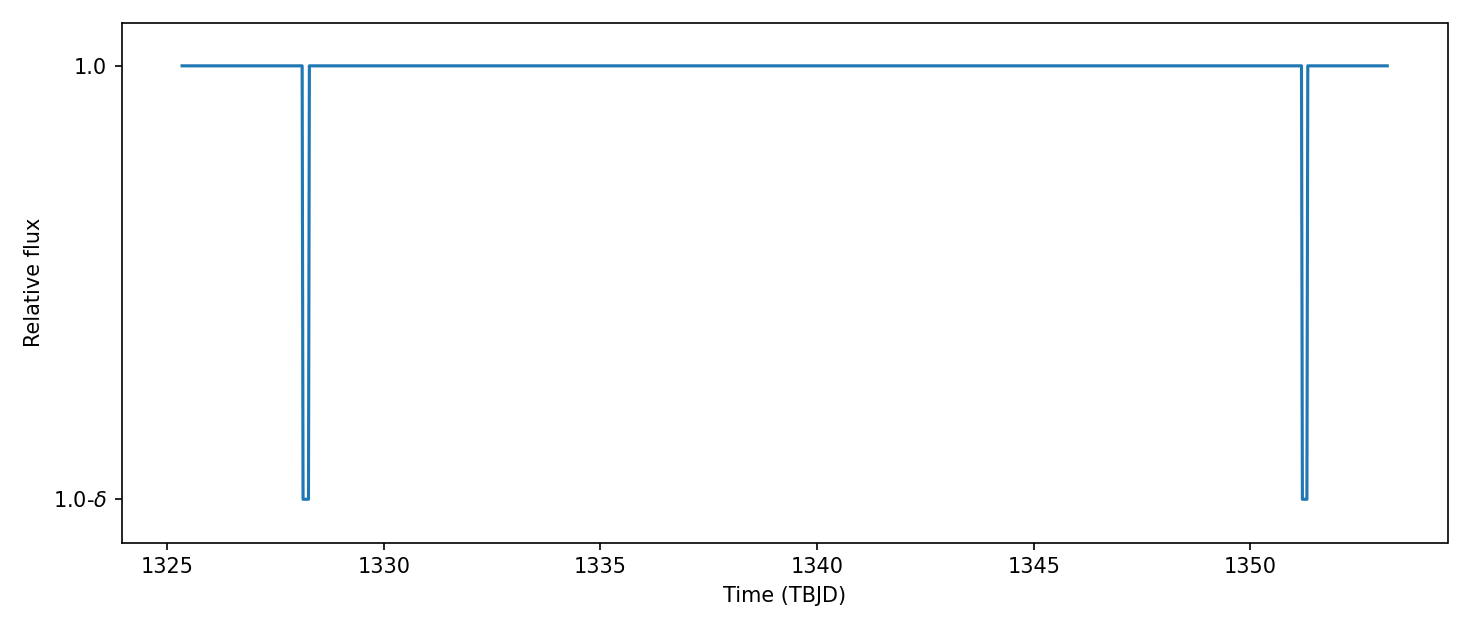

In [55]:
#Plot the simple Boolean In/out transit model
plt.figure(num=1, figsize=[9.8, 4.2])
plt.plot(TIME, np.invert(In_transit))
plt.xlabel('Time (TBJD)')
plt.ylabel('Relative flux')
plt.yticks([1.0, 0.0], ['1.0', '1.0-$\delta$'])
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


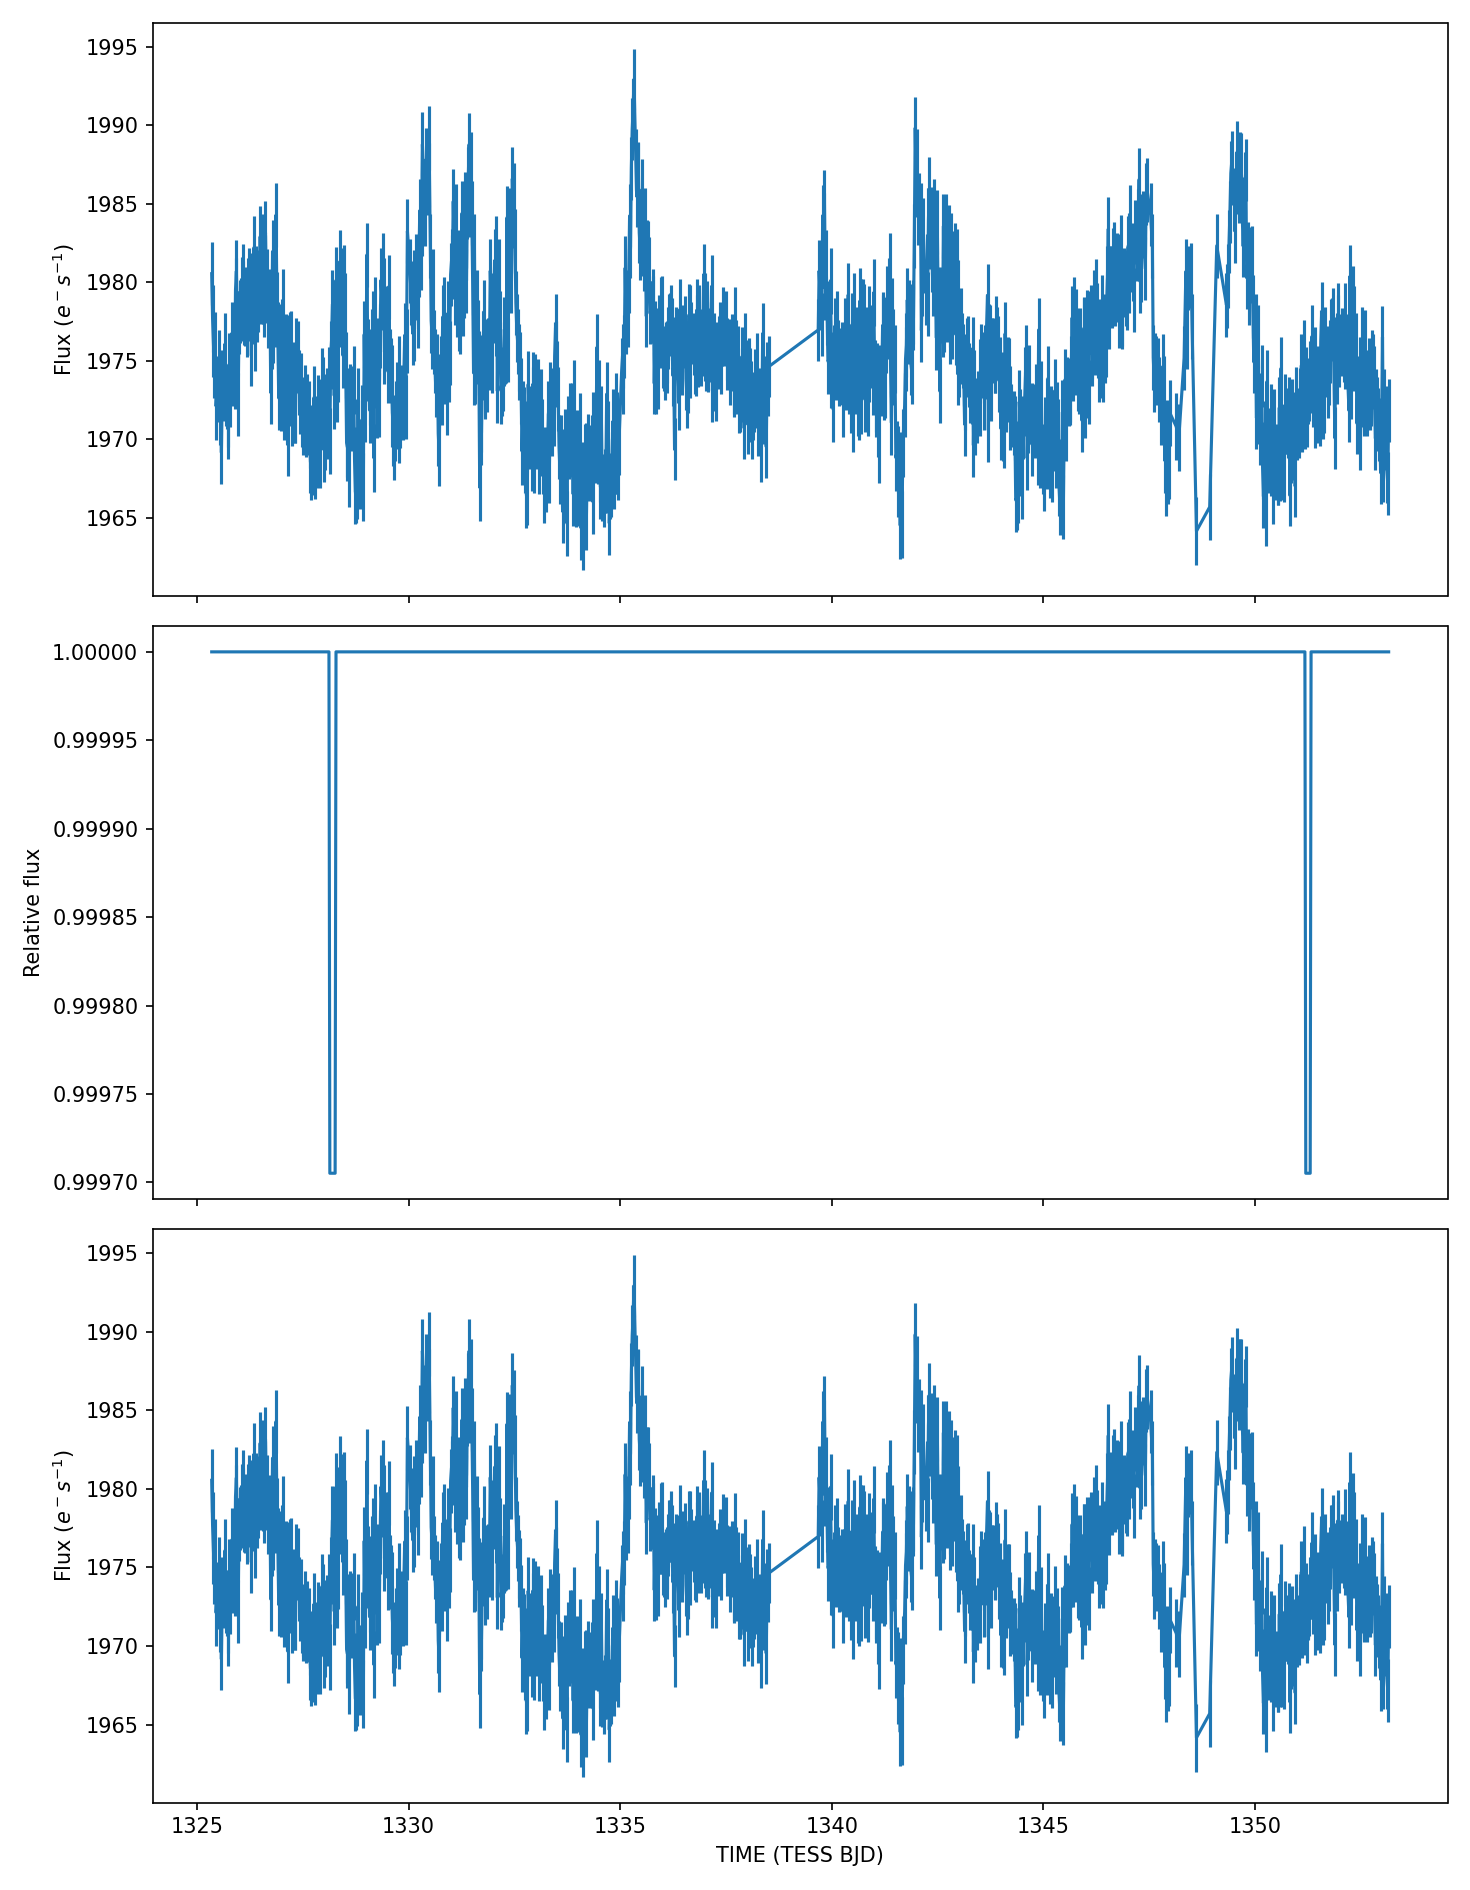

In [56]:
#Slightly more complex model with actual transit depth included
f = np.ones_like(TIME)
f[In_transit] = 1-np.square(k)
#Inject transits
inj_flux = f*FLUX
#Plot to compare
fig2, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, num=2, figsize=[9.8, 12.6])
ax1.errorbar(TIME, FLUX, FLUXERR)
ax1.set_ylabel('Flux ($e^- s^{-1}$)')
ax2.plot(TIME, f)
ax2.set_ylabel('Relative flux')
ax3.errorbar(TIME, inj_flux, FLUXERR)
ax3.set_ylabel('Flux ($e^- s^{-1}$)')
ax3.set_xlabel('TIME (TESS BJD)')
plt.tight_layout()
plt.show()
#This isn't actually how the injections will work just a neat demonstration

In [48]:
#Calculate simple signal to noise
N = float(LOG['RMS-Noise'])
SN = (np.square(k)*1000000)*(np.sqrt(0.5*T_dur/3600)/N)
LOG['S/N'] = SN

In [49]:
print(LOG)

         TIC-ID  Sector  Camera  Chip        RA        DEC    T-MAG   T_Eff  \
0  TIC 33910247       1       3     3  66.45298 -77.586801  12.4455  3853.0   

     Log-g  Metalicity  ...       R_p     Period  Periastron  Eccentricity  \
0  4.64588   -0.531169  ...  1.135489  23.054658    -1.31012      0.011916   

      Orbit_sep         k         b      cosi Inclination       S/N  
0  1.925450e+10  0.017169  0.520236  0.011267   89.354418  0.470989  

[1 rows x 29 columns]
